## 千兆病理图像癌细胞转移检测
## Detecting Cancer Metastases on Gigapixel Pathology Images

In [1]:
ls

Detecting_Cancer_Metastases_on_Gigapixel_Pathology_Images.ipynb
Detecting_Cancer_metastases/
camelyon/
data_processing.ipynb
download_Inception_V3.ipynb
retrain.ipynb


In [2]:
pwd

'/atlas/home/zwpeng/paper_rebuild'

In [3]:
import openslide

# 读取包含有肿瘤区域的大图（全切片病理图像）
origin_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/origin_images/Tumor_005.tif"
origin_slide = openslide.open_slide(origin_images_path)

# 读取该肿瘤区域的标注图
annotation_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/annotation_images/Tumor_005_Mask.tif"
mask_slide = openslide.open_slide(annotation_images_path)

In [4]:
origin_slide.level_count,origin_slide.level_dimensions,origin_slide.level_downsamples     #查看病理图片的金字塔结构

(10,
 ((97792, 219648),
  (49152, 110080),
  (24576, 55296),
  (12288, 27648),
  (6144, 13824),
  (3072, 7168),
  (1536, 3584),
  (1024, 2048),
  (512, 1024),
  (512, 512)),
 (1.0,
  1.9924660852713179,
  3.9756944444444446,
  7.951388888888889,
  15.902777777777779,
  31.238095238095237,
  62.476190476190474,
  101.375,
  202.75,
  310.0))

In [5]:
mask_slide.level_count,mask_slide.level_dimensions,mask_slide.level_downsamples     #查看标注图片的金字塔结构

(8,
 ((97792, 219648),
  (48896, 109824),
  (24448, 54912),
  (12224, 27456),
  (6112, 13728),
  (3056, 6864),
  (1528, 3432),
  (764, 1716)),
 (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0))

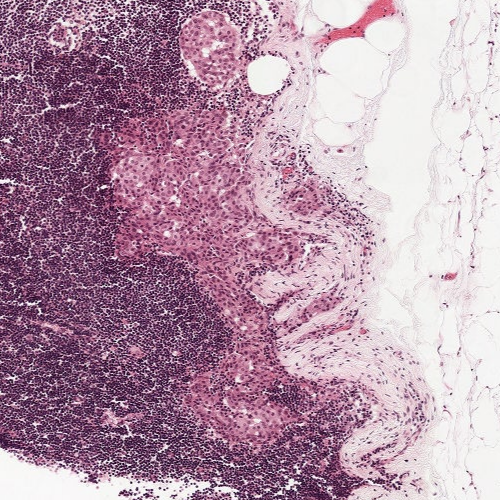

In [6]:
location=(56500,135500)
level = 3
size = (500,500)
origin_slide.read_region(location, level, size)

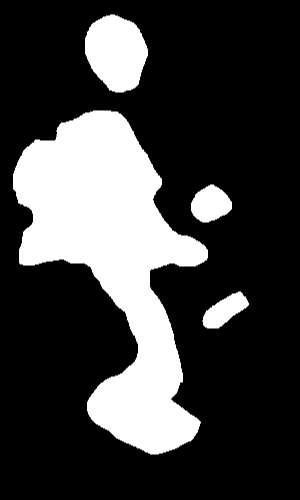

In [7]:
location=(57600,136300)
level = 3
size = (300,500)
mask_slide.read_region(location, level, size)

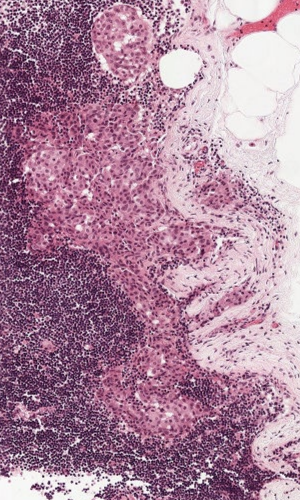

In [8]:
location=(57200,135550)
level = 3
size = (300,500)
origin_slide.read_region(location, level, size)

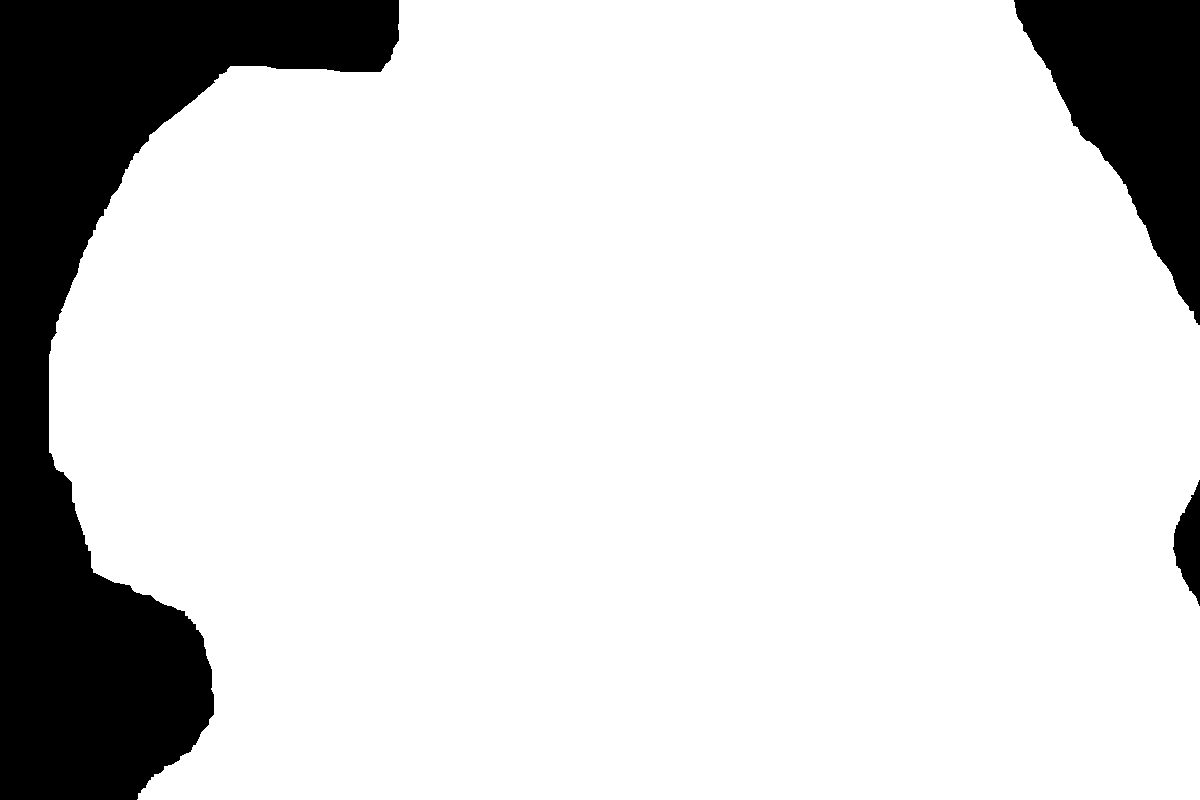

In [9]:
location=(57650,137350)
level = 0
size = (1200,800)
mask_slide.read_region(location, level, size)

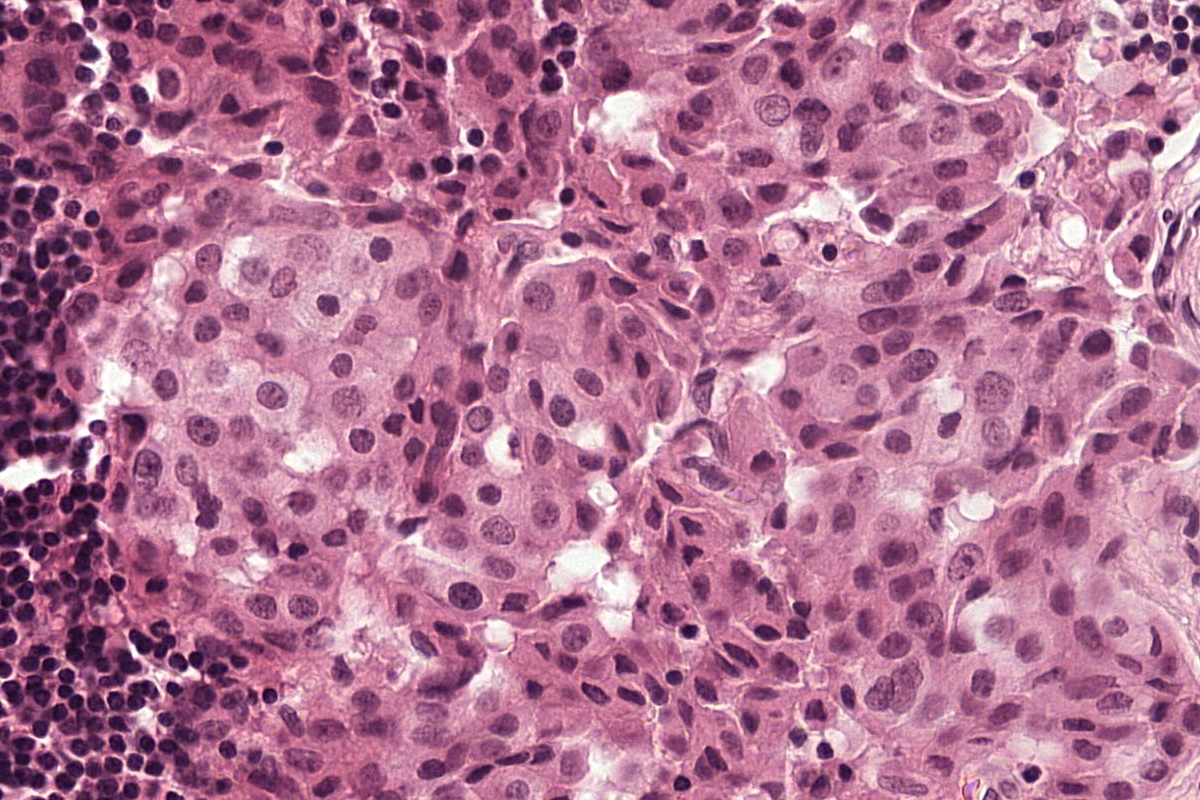

In [10]:
location=(57650,137350)
level = 0
size = (1200,800)
origin_slide.read_region(location, level, size)

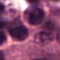

In [11]:
location=(57650,137350)
level = 0
size = (60,60)
origin_slide.read_region(location, level, size)

上面这个测试结果，可以看出，每一个细胞的大小约 20×20 （肿瘤细胞，正常细胞可能更小，约10×10）

### 在病理图片中定义随机坐标，作为随机图片的左上顶点

```
# 第一次代码
import numpy as np

widths = 299
heights = 299

# 定义随机坐标
origin_dimensions = origin_slide.dimensions
random_x = np.random.randint(0,origin_dimensions[0]-widths)
random_y = np.random.randint(0,origin_dimensions[1]-heights)

random_x,random_y
```

```
from PIL.Image import Image

random_img = (origin_slide.read_region((random_x,random_y),0,(widths,heights)))  #注意 openslide 的读取方式
random_img
```

* 下一步，以该随机坐标为顶点，读取一片区域，矩形区域的大小是 299,299

* 很明显，读取出来后，很多都是空白的，因为原始图有效区域本身就不大，有效区域只占大约10%左右（可以看level6，700×900/(1536×3584)）

* 因此，先得找到有效区域

    #### 用卷积的方式——将第9层卷积，找到有效区域，即矩形坐标 ####



人为设定有效区域

35260 144171


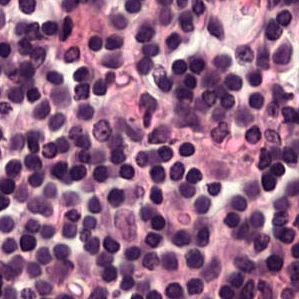

In [27]:
# 修改算法，第一次：人为给定区域

import numpy as np
from PIL.Image import Image

widths = 299
heights = 299

#人为给定有效区域
effective_x = 17650
effective_y = 125100

effective_widths = 44800
effective_heights = 57600

# 定义随机坐标


random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)

print(random_x,random_y)

random_img = (origin_slide.read_region((random_x,random_y),0,(widths,heights)))  #注意 openslide 的读取方式
random_img

可以看出，人为给出有效区域后，随机读取的图片，比较大的可能是包含有细胞的图片，效率极大提高。
然而，这种方式，是人为的手动给出 有效区域，正确的做法是 让程序自己去搜索有效区域。让随机读取的区域尽可能的没有空白。

#### 写一段代码，让程序自动找到有效区域

In [ ]:
# 修改算法，第一次：人为给定区域

import numpy as np
from PIL.Image import Image

widths = 299
heights = 299

#人为给定有效区域
effective_x = 17650
effective_y = 125100

effective_widths = 44800
effective_heights = 57600

# 定义随机坐标


random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)

print(random_x,random_y)

random_img = (origin_slide.read_region((random_x,random_y),0,(widths,heights)))  #注意 openslide 的读取方式
random_img

In [12]:
import numpy as np
def categorical(y, num_classes=None):
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical

In [13]:
def tiffTagging(dataSetName, file, randomPosition, ids, lenth):
    """
    :param dataSetName: data set name
    :param file: image file name
    :param randomPosition: random position
    :return: y
    """
    files = os.path.splitext(file)[0]
    (x, y) = randomPosition
    tifRoute = join(currentFilePath, 'documents', dataSetName, 'imageOverlays')
    taggingImgPath = join(tifRoute, files + '_Mask.tif')
    slide = openslide.open_slide(taggingImgPath)
    tile = np.array(slide.read_region((int(x), int(y)), 0, (1, 1)))
    arr = tile[:, :, :3]
    (_, _, position) = np.nonzero(arr)
    if position.__len__() is not 0:
        for name in ids:
            y = categorical.categorical(ids.index(name), num_classes=lenth + 1)
    else:
        y = categorical.categorical(lenth, num_classes=lenth + 1)
    return y


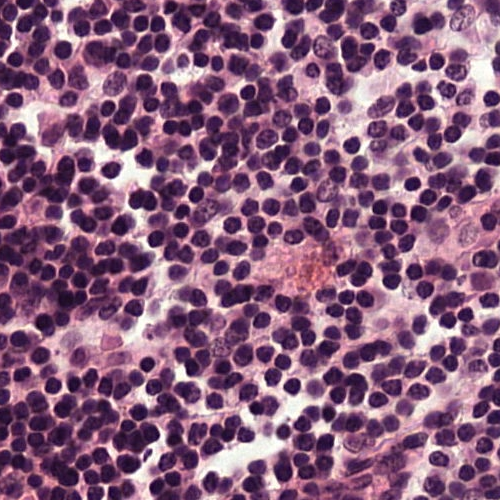

In [15]:
location=(56500,135500)
level = 0
size = (500,500)
origin_slide.read_region(location, level, size)

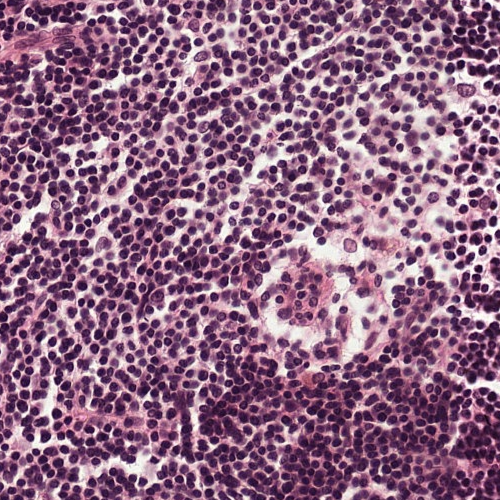

In [16]:
location=(56500,135500)
level = 1
size = (500,500)
origin_slide.read_region(location, level, size)